In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import os, warnings 
warnings.filterwarnings('ignore') 
import stan

In [ ]:
path = Path('outputs_stan')
if not os.path.exists(path):
    os.makedirs(path)

In [2]:
def ridge_wrap(adata, lam_range=[1e-3, 1e3], n_steps=4):
    """
    Wrapper function for spot-wise Ridge pipeline.
    
    Args:
        adata (AnnData): Annotated data matrix with spatial transcriptomics data
        lam_range (list): Range of lambda values for L2 regularization [min, max]
        n_steps (int): Number of steps for grid search optimization  
        
    Returns:
        AnnData: Modified adata object with Ridge regression results added
    """
    
    # Initialize empty lists to store results across all spots
    cor_list = []       # Store correlation values for each spot
    alpha_list = []     # Store optimal alpha (λ) values for each spot
    
    # 1. Prepare TFA (Transcription Factor Activity) storage matrix
    # ----------------------------------------------------------
    # Create empty DataFrame with:
    # - Rows: spot IDs (same as adata.to_df())
    # - Columns: TF names (from gene-TF matrix columns)
    adata.obsm['tfa_ridge'] = pd.DataFrame(
        index=adata.to_df().index,
        columns=adata.varm['gene_tf'].columns
    )
    
    # 2. Initialize Ridge regression model
    # -----------------------------------
    # Uses sqrt-transformed counts from 'scaled' layer
    ridge_model = stan.Ridge(adata, layer='scaled')
    
    # 3. Spot-wise processing loop
    # ---------------------------
    for spot in adata.to_df().index:
        # Update model to focus on current spot
        ridge_model.update_spot(spot)
        
        # Fit Ridge regression model with:
        # - n_steps: grid search refinement steps
        # - stages: single-stage optimization
        # - lam: L2 regularization parameter range
        ridge_model.fit(
            n_steps=n_steps,
            stages=1,
            grid_search_params={'lam': lam_range}
        )
        
        # Store optimal regularization parameter
        alpha_list.append(ridge_model.params['lam'])
        
        # Evaluate model performance (correlation between predicted/observed)
        cor = ridge_model.evaluate(fold=-1)  # -1 evaluates on all data
        cor_list.append(cor)
        
        # Store TF activities for current spot
        adata.obsm['tfa_ridge'].loc[spot, :] = ridge_model.W_concat.T
    
    # 4. Store results in AnnData object
    # --------------------------------
    adata.obs['param_ridge'] = alpha_list  # Optimal λ for each spot
    adata.obs['pred_cor_ridge'] = cor_list # Prediction correlation for each spot
    
    # Print median correlation across all spots
    print("Spot-wise correlation:" + str(round(np.nanmedian(cor_list), 4)))
    
    return adata

### CytAssist

CytAssist_FFPE_Protein_Expression_Human_Tonsil
Time elapsed: 234.03 seconds
Spot-wise correlation:0.2858
CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns
Time elapsed: 267.90 seconds
Spot-wise correlation:0.3505
CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer
Time elapsed: 201.16 seconds
Spot-wise correlation:0.0952


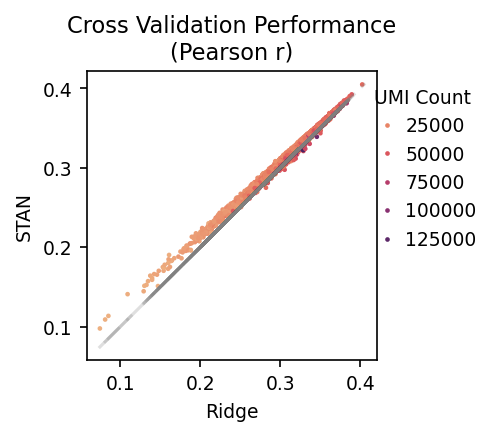

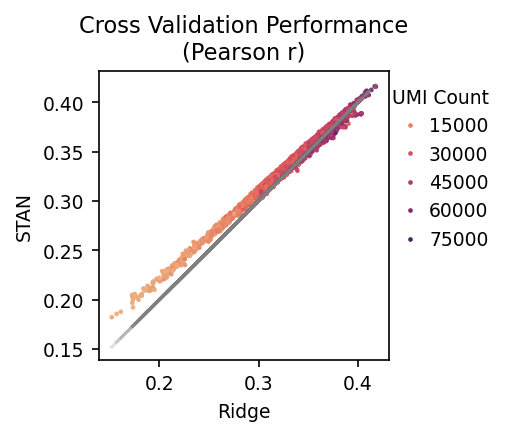

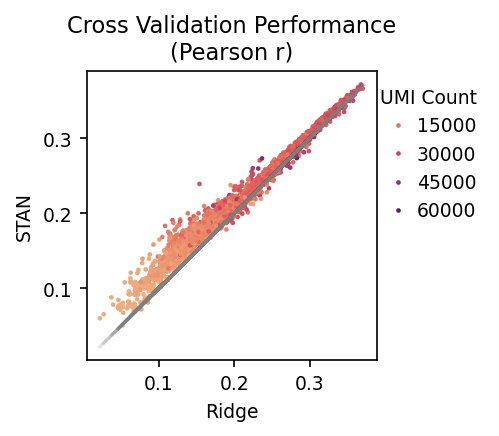

In [3]:
sample_list = ["CytAssist_FFPE_Protein_Expression_Human_Tonsil",
               "CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns",
              'CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer']
for sample_id in sample_list:
    print(sample_id)
    adata = sc.read_h5ad(f"outputs_stan/adata_{sample_id}.h5ad")
    adata = ridge_wrap(adata)
    adata.obs['pred_cor_ridge'].to_csv(path / ('adata_'+sample_id+'_pred_cor_ridge.csv'))
    adata.obsm['tfa_ridge'].to_csv(path / ('adata_'+sample_id+'_tfa_ridge.csv'))
    stan.plot_validation(adata)

CytAssist_FFPE_Protein_Expression_Human_Tonsil
Time elapsed: 234.03 seconds
Spot-wise correlation:0.2858
CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns
Time elapsed: 267.90 seconds
Spot-wise correlation:0.3505
CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer
Time elapsed: 201.16 seconds
Spot-wise correlation:0.0952


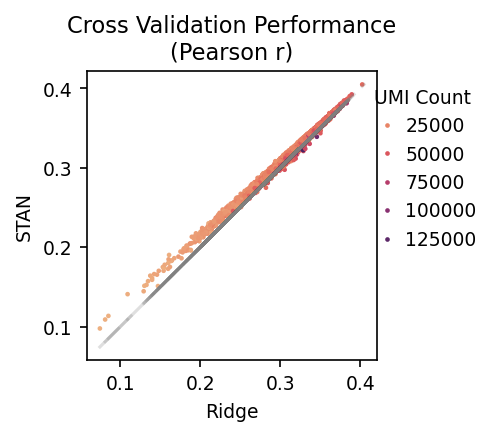

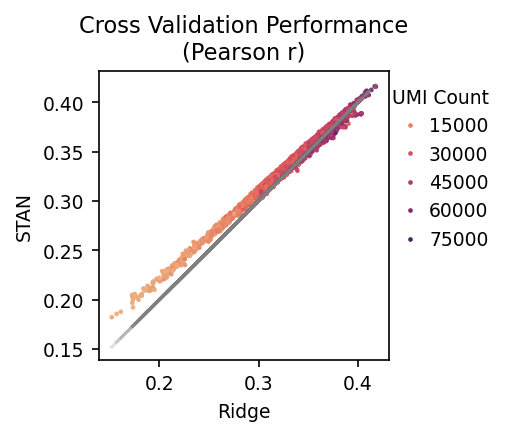

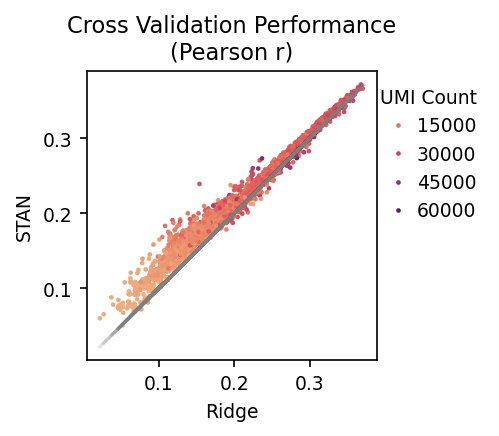

In [3]:
sample_list = ["CytAssist_FFPE_Protein_Expression_Human_Tonsil",
               "CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns",
              'CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer']
for sample_id in sample_list:
    print(sample_id)
    adata = sc.read_h5ad(f"outputs_stan/adata_{sample_id}.h5ad")
    adata = ridge_wrap(adata)
    adata.obs['pred_cor_ridge'].to_csv(path / ('adata_'+sample_id+'_pred_cor_ridge.csv'))
    adata.obsm['tfa_ridge'].to_csv(path / ('adata_'+sample_id+'_tfa_ridge.csv'))
    stan.plot_validation(adata)

In [4]:
print(adata.obs["pred_cor_stan"].mean())
print(adata.obs["pred_cor_stan"].std())
print(adata.obs["pred_cor_ridge"].mean())
print(adata.obs["pred_cor_ridge"].std())

0.20601390456839033
0.05559666862379205
0.19188093853105842
0.06134724325750472


In [5]:
from scipy.stats import pearsonr, spearmanr, wilcoxon
wilcoxon(adata.obs["pred_cor_stan"], adata.obs["pred_cor_ridge"], 
         zero_method='wilcox', correction=False, alternative='greater')

WilcoxonResult(statistic=8608881.0, pvalue=0.0)

### ST

In [ ]:
sample_id = "V1_Human_Lymph_Node"
adata = sc.read_h5ad(f"outputs_stan/adata_{sample_id}.h5ad")
adata = stan.annotate_lymphnode(adata, fpath="resources/lymphnode_annotation")
adata = ridge_wrap(adata)
adata.obs['pred_cor_ridge'].to_csv(path / ('adata_'+sample_id+'_pred_cor_ridge.csv'))
adata.obsm['tfa_ridge'].to_csv(path / ('adata_'+sample_id+'_tfa_ridge.csv'))
stan.plot_validation(adata, xstring="pred_cor_ridge")

1142243F
Time elapsed: 127.99 seconds
Spot-wise correlation:0.2144
1160920F
Time elapsed: 164.51 seconds
Spot-wise correlation:0.1595
CID4290
Time elapsed: 80.13 seconds
Spot-wise correlation:0.178
CID4535
Time elapsed: 45.91 seconds
Spot-wise correlation:0.2112
CID4465
Time elapsed: 49.06 seconds
Spot-wise correlation:0.2002
CID44971
Time elapsed: 43.67 seconds
Spot-wise correlation:0.1422


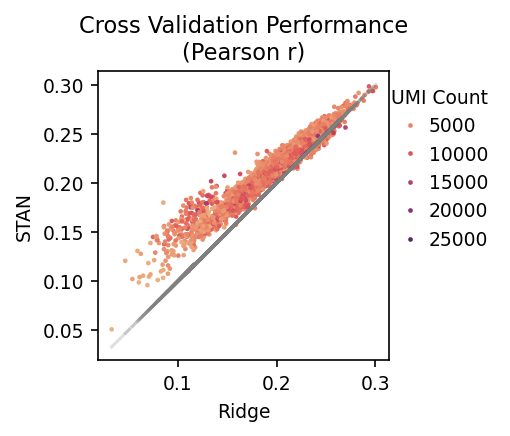

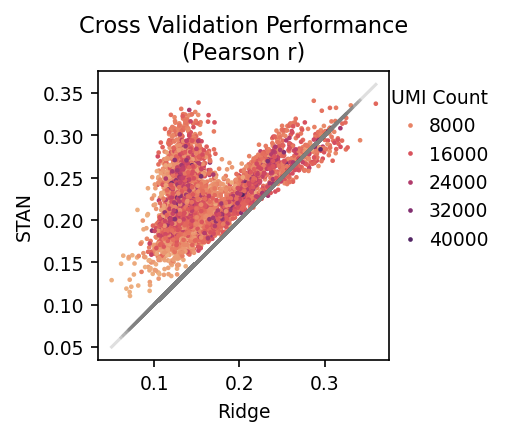

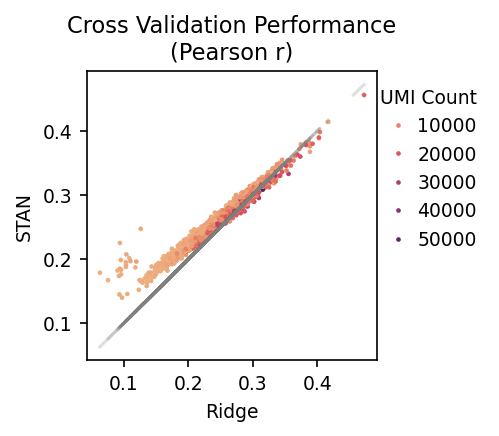

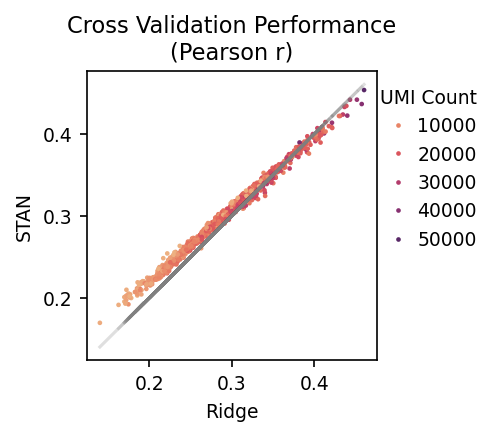

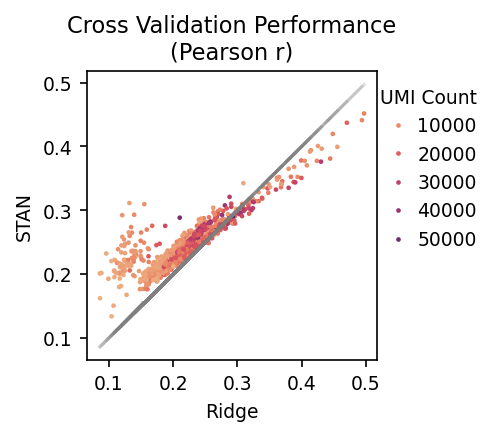

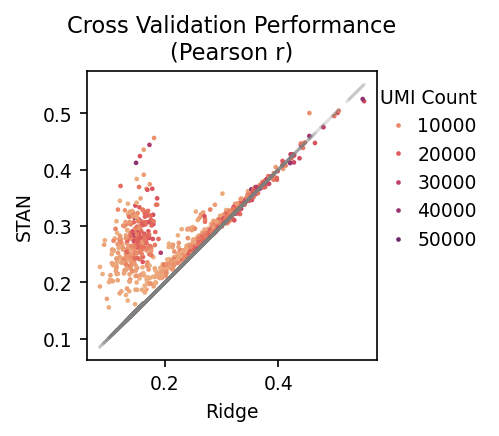

In [7]:
sample_list = ["1142243F", "1160920F", "CID4290", "CID4535", "CID4465", "CID44971"]
for sample_id in sample_list:
    print(sample_id)
    adata = sc.read_h5ad(path / ('adata_Breast_Wu_'+sample_id+'.h5ad'))
    adata = ridge_wrap(adata)
    adata.obs['pred_cor_ridge'].to_csv(path / ('adata_Breast_Wu_'+sample_id+'_pred_cor_ridge.csv'))
    adata.obsm['tfa_ridge'].to_csv(path / ('adata_Breast_Wu_'+sample_id+'_tfa_ridge.csv'))
    stan.plot_validation(adata)

Time elapsed: 122.32 seconds
Spot-wise correlation:0.2119


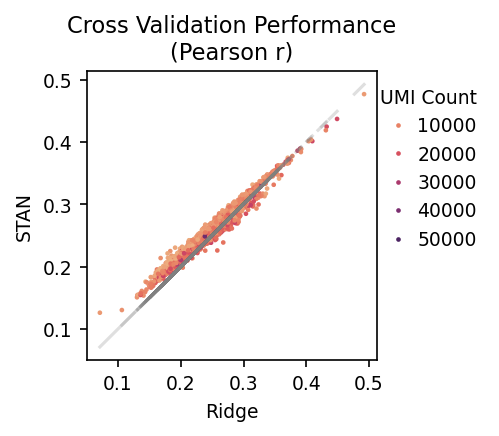

In [8]:
sample_id = "Parent_Visium_Human_Glioblastoma"
adata = sc.read_h5ad(f"outputs_stan/adata_{sample_id}.h5ad")
adata = ridge_wrap(adata)
adata.obs['pred_cor_ridge'].to_csv(path / ('adata_'+sample_id+'_pred_cor_ridge.csv'))
adata.obsm['tfa_ridge'].to_csv(path / ('adata_'+sample_id+'_tfa_ridge.csv'))
stan.plot_validation(adata, xstring="pred_cor_ridge")